# Robustness Assessment
In this notebook, the plausible policies resulting from the directed search notebook, will be tested on their robustness using the critical scenarios defined in the scenario discovery

In [40]:
# Import libraries 
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


# Import EMA workbench
from ema_workbench import MultiprocessingEvaluator
from ema_workbench import Policy, Scenario
from ema_workbench.analysis import parcoords

# Import files
from problem_formulation import get_model_for_problem_formulation

In [3]:
# Even tough the run has been done on Delft Blue, the model initizalization is needed for the analysis of the optimization results and the robustness analysis

problem_formulation = 3
model, steps = get_model_for_problem_formulation(problem_formulation)

uncertainties = model.uncertainties
levers = model.levers
outcomes = model.outcomes

In [4]:
# Read in the datasets
plausible_policies = pd.read_csv('../data/plausible_policies.csv')
critical_scenarios = pd.read_csv('data/merged_scenarios_cleaned.csv')

In [70]:
plausible_policies

,Unnamed: 0.1,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,A.4_DikeIncrease 0,A.5_DikeIncrease 0,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,total_costs [mil],total_RfR
0,6,6,1,0,1,1,0,0,0,3,3,3,3,0.0,1.108457e+08,236500000.0,0.0,0.0,347.345666,3
1,128,128,1,1,1,1,0,0,0,3,3,3,3,0.0,1.108457e+08,454300000.0,0.0,0.0,565.145665,4
2,223,223,0,0,1,0,0,1,2,4,3,5,5,0.0,1.625573e+08,30700000.0,0.0,0.0,193.257257,1
3,227,227,1,0,0,1,0,3,0,4,4,3,3,0.0,1.185669e+08,205800000.0,0.0,0.0,324.366886,2
4,288,288,1,0,1,0,0,3,0,4,3,5,5,0.0,1.253021e+08,115300000.0,0.0,0.0,240.602053,2
5,373,373,1,0,0,0,0,2,0,4,4,4,6,0.0,1.297308e+08,84600000.0,0.0,0.0,214.330821,1


In [5]:
# In order to input the to-be-tested policies on their robustness in different scenarios through the EMA workbench, they need to be reformatted into a list as policy objects first

policies_to_evaluate = []

for i, policy in plausible_policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [6]:
# Reformat the scenarios into a list of scenario objects as well

critical_scenarios = critical_scenarios.drop(columns=['policy', 'model'])
critical_scenarios_dict = critical_scenarios.to_dict('index')

scenarios_to_evaluate = []
for key in critical_scenarios_dict.keys():
    scenarios_to_evaluate.append(Scenario(key, **critical_scenarios_dict[key]))

>> When re-running the analysis, comment the next to cells in

In [7]:
# # Test each of the policies across all of the identified critical scenarios
# 
# with MultiprocessingEvaluator(model) as evaluator:
#     results_rob = evaluator.perform_experiments(scenarios_to_evaluate, policies_to_evaluate)

100%|██████████████████████████████████| 60000/60000 [1:26:29<00:00, 11.56it/s]


In [10]:
# experiments_rob, outcomes_rob = results_rob
# 
# df_outcomes_rob = pd.DataFrame(outcomes_rob)
# df_outcomes_rob.to_csv('data/outcomes_rob.csv')
# 
# df_experiments_rob = pd.DataFrame(experiments_rob)
# df_experiments_rob.to_csv('data/experiments_rob.csv')

In [ ]:
df_experiments_rob = pd.read_csv('data/experiments_rob.csv')
df_outcomes_rob = pd.read_csv('data/outcomes_rob.csv')

In [23]:
df_outcomes_rob.columns

Index(['A.1_Dike Investment Costs', 'A.1_Expected Annual Damage',
       'A.1_Expected Number of Deaths', 'A.2_Dike Investment Costs',
       'A.2_Expected Annual Damage', 'A.2_Expected Number of Deaths',
       'A.3_Dike Investment Costs', 'A.3_Expected Annual Damage',
       'A.3_Expected Number of Deaths', 'A.4_Dike Investment Costs',
       'A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths',
       'A.5_Dike Investment Costs', 'A.5_Expected Annual Damage',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs', 'total_dike_investment', 'total_costs',
       'total_deaths', 'total_damage'],
      dtype='object')

In [102]:
# Aggregate results robustness run
df_outcomes_rob['total_dike_investment'] = df_outcomes_rob[[f"A.{i+1}_Dike Investment Costs" for i in range(5)]].sum(axis=1)
df_outcomes_rob['total_costs_mil'] = (df_outcomes_rob['total_dike_investment'] + df_outcomes_rob['RfR Total Costs'] + df_outcomes_rob['Expected Evacuation Costs'])/1000000
df_outcomes_rob['total_deaths'] = df_outcomes_rob[[f'A.{i+1}_Expected Number of Deaths' for i in range(5)]].sum(axis=1)
df_outcomes_rob['total_damage_mil'] = (df_outcomes_rob[[f'A.{i+1}_Expected Annual Damage' for i in range(5)]].sum(axis=1))/1000000
dict_outcomes_rob = df_outcomes_rob.to_dict('list')

In [95]:
df_outcomes_rob = df_outcomes_rob.reset_index(drop=True)
df_experiments_rob = df_experiments_rob.reset_index(drop=True)

# Merge robustness run outcomes and experiments
df_rob = pd.concat([df_experiments_rob, df_outcomes_rob], axis=1)

In [130]:
df_rob[df_rob['policy']=='5'].describe()

,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.2_Bmax,A.2_pfail,A.3_Bmax,A.3_pfail,A.4_Bmax,A.4_pfail,A.5_Bmax,...,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,total_dike_investment,total_costs,total_deaths,total_damage,total_costs_mil
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,1.000000e+04,1.000000e+04,10000.000000,10000.0,10000.000000,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,10000.000000
mean,66.000800,190.000128,0.500000,190.000042,0.500000,190.000003,0.500000,190.000056,0.500000,190.000019,...,4.027367e+07,2.768388e+06,0.000352,84600000.0,2938.504755,1.297308e+08,2.143338e+08,0.021955,2.067494e+08,214.333759
std,38.394833,92.380622,0.288689,92.380575,0.288689,92.380792,0.288689,92.380835,0.288690,92.380603,...,1.490191e-08,1.477882e+07,0.001845,0.0,4831.210399,2.980381e-08,4.831210e+03,0.037137,3.844363e+08,0.004831
min,0.000000,30.002793,0.000033,30.026305,0.000049,30.031605,0.000060,30.014574,0.000071,30.025937,...,4.027367e+07,0.000000e+00,0.000000,84600000.0,0.000000,1.297308e+08,2.143308e+08,0.000000,0.000000e+00,214.330821
25%,33.000000,109.997904,0.249996,110.006485,0.250020,110.016734,0.249987,110.010287,0.250035,110.017758,...,4.027367e+07,0.000000e+00,0.000000,84600000.0,220.422947,1.297308e+08,2.143310e+08,0.001005,7.135873e+06,214.331041
50%,66.000000,189.998437,0.499978,190.007089,0.499974,189.994112,0.499972,190.005135,0.499997,190.003826,...,4.027367e+07,0.000000e+00,0.000000,84600000.0,838.069259,1.297308e+08,2.143317e+08,0.003944,2.674794e+07,214.331659
75%,99.000000,269.995481,0.750001,269.998563,0.749963,269.985408,0.749974,269.989758,0.750009,269.997574,...,4.027367e+07,0.000000e+00,0.000000,84600000.0,3669.525459,1.297308e+08,2.143345e+08,0.017747,1.362270e+08,214.334490
max,132.000000,349.994978,0.999958,349.968349,0.999911,349.979725,0.999901,349.982768,0.999909,349.988550,...,4.027367e+07,3.134856e+08,0.049782,84600000.0,43139.148379,1.297308e+08,2.143740e+08,0.262462,2.681723e+09,214.373960


With the results from this tun, the robustness of each policy in terms of each outcome indicator can be identified,as well as the robustness tradeoffs. This will be done using the maximum regret metric

### Maximum regret - aggregated outcomes
For each policy under each scenario, the difference between the performance of that scenario, and the best possible result in that scenario is calculated, reflecting the regret. As the maximum regret is the maximum of the regret values across all scenarios, policies with low maximum regret values are preferred. As analyst for Rijkswaterstaat, we are mostly interested in the aggregated results 

In [123]:
overall_agg_regret = {}
max_agg_regret = {}

# Calculate regret for aggregate outcomes, using the same steps as before
for name in ["total_costs_mil", "total_damage_mil","total_deaths"]:
    # policy_column = experiments_rob['policy']
   
    data_agg_max_regret = pd.DataFrame({name: df_outcomes_rob[name], 
                         "policy":experiments_rob['policy'],
                         "scenario":experiments_rob['scenario']})
    
    data_agg_max_regret = data_agg_max_regret.pivot(index='scenario', columns='policy')
    data_agg_max_regret.columns = data_agg_max_regret.columns.get_level_values(1)
    
    data_agg_max_regret_array = data_agg_max_regret.to_numpy()
    
    outcome_agg_regret = np.abs(data_agg_max_regret_array.min(axis=1)[:, np.newaxis] - data_agg_max_regret_array)
    
    outcome_agg_regret_df = pd.DataFrame(outcome_agg_regret, index=data_agg_max_regret.index, columns=data_agg_max_regret.columns)
    
    overall_agg_regret[name] = outcome_agg_regret_df
    max_agg_regret[name] = outcome_agg_regret_df.max()

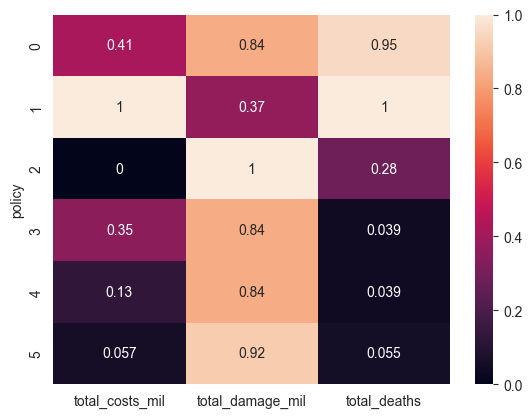

In [157]:
# Plot the max-regret heatmap -aggregated results
max_agg_regret = pd.DataFrame(max_agg_regret)
sns.heatmap(max_agg_regret/max_agg_regret.max(), annot=True)
plt.show()

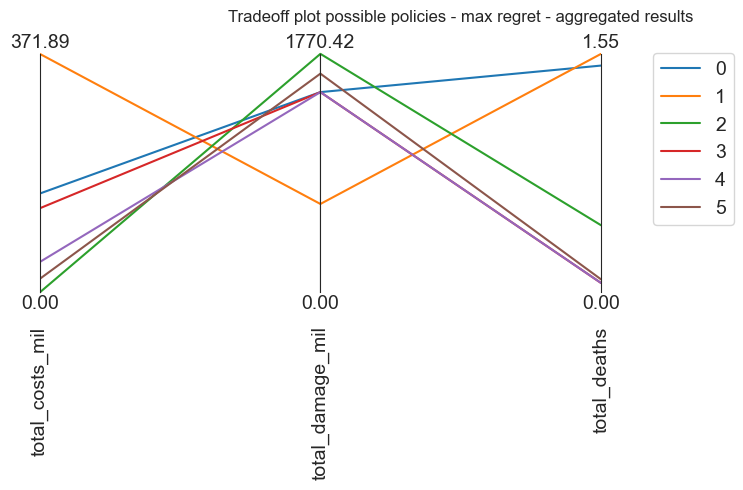

In [163]:
# Plot the tradeoffs of the possible policies
colours = sns.color_palette(n_colors=len(plausible_policies))

ooi = ["total_costs_mil", "total_damage_mil","total_deaths"]
limits = parcoords.get_limits(max_agg_regret)
limits.loc[0, ooi] = 0
paraxes = parcoords.ParallelAxes(limits)

for i, (index, row) in enumerate(max_agg_regret.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colours[i])
paraxes.legend()

plt.title('Tradeoff plot possible policies - max regret - aggregated results')    
plt.show()

As can be deducted from the heatmap and the trade-off plot, neither of the plausible policies is perfect in the worst-case scenarios for the regional levels. What is especially interesting, as that while the number of deaths are minimized in the selection of plausible policies, they all will result in expected annual deaths in the worst-case regional scenario.

## Worst case scenario - deaths
One of the political no-go's of Rijkswaterstaat was the least amounts of expected causulties possible. While the max-regret metric gives a good insight in how policies 0 and 1 perform overall, we want to take a look at the distrubtion of the total causulties in the worst case scenarios. 

In [132]:
df_outcomes_rob['total_deaths'].describe()

count    60000.000000
mean         0.055361
std          0.132999
min          0.000000
25%          0.001723
50%          0.007759
75%          0.043819
max          1.699388
Name: total_deaths, dtype: float64

In [131]:
df_deaths = df_rob[df_rob['total_deaths'] > 1]
df_deaths['policy'].value_counts()

policy
0    78
1    71
2     0
3     0
4     0
5     0
Name: count, dtype: int64

The results above makes at clear that in the worst case scenario, policies 0 and 1 will result in a high number of expected deaths. Therefor, they will be removed from further analysis

## Boxplot - distribution of costs and benefits
To ensure that the distribution of costs is not crooked towards one province, boxplots regarding the expected annual damage and expected number of deaths for the three most optimal policies are plot.  

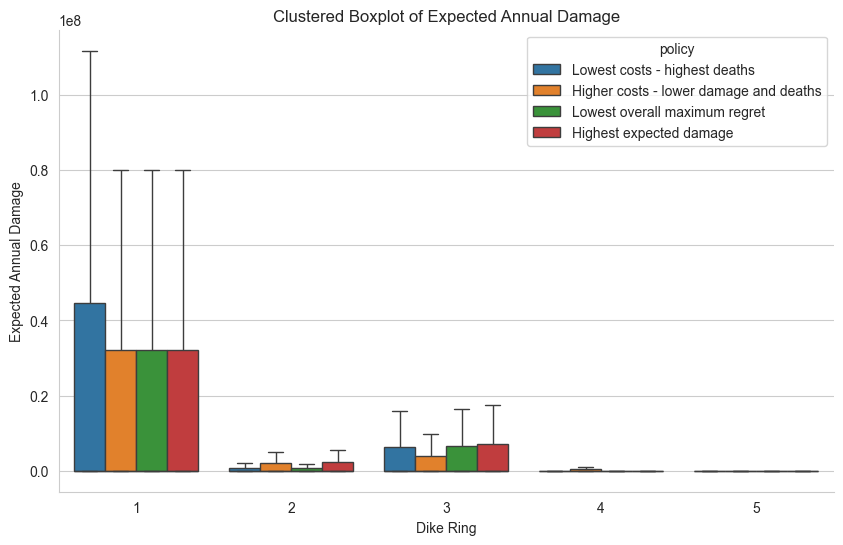

In [162]:
#create clustered boxplot of policies [2,3,4,5] for all dike rings
df_rob['policy'] = pd.to_numeric(df_rob['policy'])
boxplot_data = df_rob[df_rob['policy'].isin([2,3,4,5])]
df_policies_boxplot = boxplot_data['policy']
boxplot_data_damage = boxplot_data[[f'A.{i+1}_Expected Annual Damage' for i in range(5)]]
df_damage = pd.concat([df_policies_boxplot, boxplot_data_damage], axis=1)

#rename expected annual damage columns to dike ring names by number
df_damage = df_damage.rename(columns={'A.1_Expected Annual Damage': '1', 'A.2_Expected Annual Damage': '2', 'A.3_Expected Annual Damage': '3', 'A.4_Expected Annual Damage': '4', 'A.5_Expected Annual Damage': '5'})

policy_to_name_dict = {
    2: 'Lowest costs - highest deaths',
    3: 'Higher costs - lower damage and deaths',
    4: 'Lowest overall maximum regret',
    5: 'Highest expected damage'
}
df_damage['policy'] = df_damage['policy'].map(policy_to_name_dict)
df_renamed = pd.DataFrame(df_damage)

# Melt the DataFrame to convert columns into a single 'Damage' column
melted_df = pd.melt(df_renamed, id_vars='policy', var_name='Dike Ring', value_name='Expected Annual Damage')

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(x='Dike Ring', y='Expected Annual Damage', hue='policy', data=melted_df, showfliers=False, ax=ax)

# Disable the right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Set labels and title
plt.xlabel('Dike Ring')
plt.ylabel('Expected Annual Damage')
plt.title('Clustered Boxplot of Expected Annual Damage')

# Display the plot
plt.show()

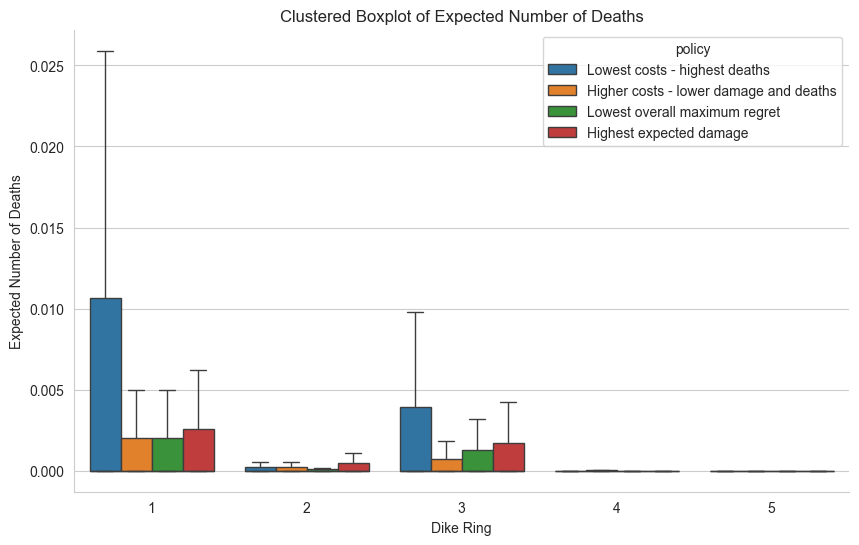

In [161]:
#create clustered boxplot of policies [2,3,4,5] for all dike rings
boxplot_data_deaths = boxplot_data[[f'A.{i+1}_Expected Number of Deaths' for i in range(5)]]
df_deaths = pd.concat([df_policies_boxplot, boxplot_data_deaths], axis=1)

#rename expected annual damage columns to dike ring names by number
df_deaths = df_deaths.rename(columns={'A.1_Expected Number of Deaths': '1', 'A.2_Expected Number of Deaths': '2', 'A.3_Expected Number of Deaths': '3', 'A.4_Expected Number of Deaths': '4', 'A.5_Expected Number of Deaths': '5'})

df_deaths['policy'] = df_deaths['policy'].map(policy_to_name_dict)
df_renamed = pd.DataFrame(df_deaths)

# Melt the DataFrame to convert columns into a single 'Damage' column
melted_df = pd.melt(df_renamed, id_vars='policy', var_name='Dike Ring', value_name='Expected Number of Deaths')

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(x='Dike Ring', y='Expected Number of Deaths', hue='policy', data=melted_df, showfliers=False, ax=ax)

# Disable the right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Set labels and title
plt.xlabel('Dike Ring')
plt.ylabel('Expected Number of Deaths')
plt.title('Clustered Boxplot of Expected Number of Deaths')

# Display the plot
plt.show()